## Setting Up

In [1]:
!pip install lime shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 30.4 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=d52bab8c6155c00e23e6ce29ac04676c3d0c9473628acc1922487917b1012723
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

import lime.lime_tabular

# Helpers

In [5]:
def grid_search_cv_optimization(X_train, y_train, model, cv_method, model_params):
  """
    performs parameter optimization using grid-search cross validation
    ==================================================================
    X_train:    Predictor variable

    y_train:    Class variable

    model:      Model instance e.g ( GaussianNB() )

    model_params:  Dictionary with parameters as keys, and arrays of values to
                iterate for optimizing the corresponding parameter (key) as the
                value
  """
  estimator = GridSearchCV(estimator=model, 
                  param_grid=model_params, 
                  cv=cv_method,   # use any cross validation technique 
                  verbose=1, 
                  scoring='accuracy') 
  estimator.fit(X_train, y_train)
  return estimator

def random_search_cv_optimization(X_train, y_train, model, 
                                  parameters, n_iter,
                                  scoring="accuracy", cv=10):
  """
    performs parameter optimization using random-search cross validation
    ====================================================================
    X_train: Predictor variables
    y_train: Class variables
    model: estimator instance e.g (XGBClassifier())
    parameters: Parameter space
    n_iter: number of iterations
    scoring: Cross validation evaluation metric
    cv: Cross validation folds
  """
  rs = RandomizedSearchCV(model, param_distributions=parameters,
                        n_iter=n_iter, scoring=scoring, random_state=0,
                        n_jobs=-1, cv=cv, return_train_score=True)

  rs.fit(X_train, y_train)
  return rs 

def plot_learning_curve(train_results,
                        test_results,
                        x_label,
                        y_label,
                        title):
  """
    plots the learning curves
    ==================================================================
    train_results: learning history for train set (could be, accuracy, auc, etc)
    test_results: learning history for test set (could be, accuracy, auc, etc)
    x_label: X axis label
    y_label: Y axis label
    title: plot title
  """
  train_x = range(0, len(train_results))
  train_y = train_results

  test_x = range(0, len(test_results))
  test_y = test_results
  
  plt.plot(train_x, train_y, color='r', label="train")
  plt.plot(test_x, test_y, color='g', label="test")

  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()


def plot_confusion_matrix(y_test, y_pred, title, normalize="true"):
  xgb_cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  metrics.ConfusionMatrixDisplay(confusion_matrix=xgb_cm,
                                display_labels=["no churn", "churn"]).\
                                plot(cmap=plt.cm.Blues)
  plt.title(title)
  plt.show()

In [6]:
print("Scores\n")
sorted(metrics.SCORERS.keys())

Scores



['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

# Prepare the dataset

In [7]:
dataset_path = "/content/drive/MyDrive/School/MSc Computer Science/sem1"\
                " - (Ben Wycliff)/Sudi and Ben/Project/Berka dataset/"\
                "berka_dataset_with_state2.csv"

dataset = pd.read_csv(dataset_path)

# drop unusable features
dataset= dataset.drop(columns=['client_id',
                          'account_id',
                          'district_id',
                          'disp_id',
                          'branch_location_id'], axis=1) 


# Convert all categorical columns to label encoding

# create label encoder object
le = LabelEncoder()
  
dataset['gender']= le.fit_transform(dataset['gender'])
dataset['district_of_residence']= le.fit_transform(dataset['district_of_residence'])
dataset['owns_account']= le.fit_transform(dataset['owns_account'])
dataset['f_statement_issuance']= le.fit_transform(dataset['f_statement_issuance'])
dataset['branch_location']= le.fit_transform(dataset['branch_location'])
dataset['insurance_payment']= le.fit_transform(dataset['insurance_payment'])
dataset['household_payment']= le.fit_transform(dataset['household_payment'])
dataset['lease_payment']= le.fit_transform(dataset['lease_payment'])
dataset['loan_payment']= le.fit_transform(dataset['loan_payment'])
dataset['has_credit_card']= le.fit_transform(dataset['has_credit_card'])
dataset['has_had_loan']= le.fit_transform(dataset['has_had_loan'])
dataset['loan_pay_success']= le.fit_transform(dataset['loan_pay_success'])
dataset['loan_pay_failure']= le.fit_transform(dataset['loan_pay_failure'])
dataset['in_loan_debt']= le.fit_transform(dataset['in_loan_debt'])



# create target and feature variables
y = dataset["State"]
X = dataset.drop("State", axis=1)

features = X.columns
print(f"Feature variables: {features} \n")

# scale features
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

# dimensionality reduction with PCA
# pca = PCA(n_components=0.95, whiten=True)
# X_pca = pca.fit_transform(X_scaled)

# print(f"Number of features before PCA: {X.shape[1]}")
# print(f"Number of features after PCA: {X_pca.shape[1]}")


Feature variables: Index(['age', 'gender', 'district_of_residence', 'district_inhabitant_count',
       'district_cities_count', 'district_urban_inhabitant_ratio',
       'district_average_salary', 'district_mun_inhabitant_count_499',
       'district_mun_inhabitant_count_1999',
       'district_mun_inhabitant_count_9999',
       'district_mun_inhabitant_count_infinite',
       'district_enterprenuer_per_1000', 'district_crimes_count',
       'district_unemployment_rate', 'owns_account', 'tenure',
       'f_statement_issuance', 'branch_location', 'orders_count',
       'insurance_payment', 'household_payment', 'lease_payment',
       'loan_payment', 'has_credit_card', 'transaction_count',
       'withdraw_transactions', 'credit_transactions',
       'credit_card_withdrawals', 'credit_in_cash',
       'collections_from_other_banks', 'cash_withdrawals',
       'remittance_to_other_banks', 'has_had_loan', 'max_loan_amount',
       'max_loan_duration', 'loan_pay_success', 'loan_pay_failure

(5369, 40)

In [8]:
print("Class variable: ")
y.head()

Class variable: 


0    0
1    1
2    1
3    0
4    0
Name: State, dtype: int64

In [9]:
print("Dataset: ")
dataset.head()

Dataset: 


State   age  gender  district_of_residence  district_inhabitant_count  \
0      0  29.0       0                     46                    70699.0   
1      1  54.0       1                     17                  1204953.0   
2      1  59.0       0                     17                  1204953.0   
3      0  43.0       1                     29                    95616.0   
4      0  39.0       0                     29                    95616.0   

   district_cities_count  district_urban_inhabitant_ratio  \
0                    4.0                             65.3   
1                    1.0                            100.0   
2                    1.0                            100.0   
3                    6.0                             51.4   
4                    6.0                             51.4   

   district_average_salary  district_mun_inhabitant_count_499  \
0                   8968.0                               60.0   
1                  12541.0                                0.0   
2                  12541.0                                0.0   
3                   9307.0                               65.0   
4                   9307.0                               65.0   

   district_mun_inhabitant_count_1999  ...  cash_withdrawals  \
0                                13.0  ...              97.0   
1                                 0.0  ...             237.0   
2                                 0.0  ...             237.0   
3                                30.0  ...              32.0   
4                                30.0  ...              32.0   

   remittance_to_other_banks  has_had_loan  max_loan_amount  \
0                       40.0             0              0.0   
1                       89.0             1          80952.0   
2                       89.0             1          80952.0   
3                       39.0             0              0.0   
4                       39.0             0              0.0   

   max_loan_duration  loan_pay_success  loan_pay_failure  in_loan_debt  \
0                0.0                 0                 0             0   
1               24.0                 1                 0             0   
2               24.0                 1                 0             0   
3                0.0                 0                 0             0   
4                0.0                 0                 0             0   

   year_of_last_transaction  year_of_last_credit  
0                      98.0                 98.0  
1                      98.0                 98.0  
2                      98.0                 98.0  
3                      98.0                 98.0  
4                      98.0                 98.0  

[5 rows x 41 columns]

## Create Dataset Split

In [10]:
# current data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0)
# oversample dataset using SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

# XAI

### Lime configuration

In [11]:
# features
# features = list(X_train_resampled.columns)
# Lime explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_resampled, 
                                                        feature_names=features,
                                                        verbose=True,
                                                        mode='classification')

In [12]:
X_df = pd.DataFrame(X_test)
# X_df.columns = features
X_df

0         1         2         3         4         5         6   \
0    -0.277862  0.985393 -0.837385  2.606210 -1.536510  1.546114  2.277413   
1    -0.798675 -1.014824  0.171800 -0.300971  1.524285  0.023119 -0.625869   
2     0.127215 -1.014824  0.447032 -0.543759  0.504020 -0.394071 -1.049750   
3    -1.608828 -1.014824  0.492904 -0.553127 -0.516245 -0.198042 -0.407917   
4    -1.088015  0.985393 -0.837385  2.606210 -1.536510  1.546114  2.277413   
...        ...       ...       ...       ...       ...       ...       ...   
1606  0.069347  0.985393  0.355288  0.152053 -1.536510  1.546114  0.873496   
1607 -0.798675 -1.014824  0.814009 -0.365578 -0.176157 -0.233226 -0.519899   
1608  0.648028 -1.014824  1.364473 -0.607124 -0.516245 -0.504651 -0.436476   
1609 -0.335730 -1.014824 -0.837385  2.606210 -1.536510  1.546114  2.277413   
1610 -0.798675  0.985393  0.859881 -0.449591  0.163932 -0.564968 -0.568751   

            7         8         9   ...        30        31        32  \
0    -1.150070 -1.365433 -1.255021  ... -0.023465  0.566848  2.343532   
1    -1.004973  0.938860  1.262737  ... -1.576570 -0.973067 -0.426706   
2     1.722868 -0.377879 -0.339473  ...  1.240691  1.942505  2.343532   
3     0.591104 -0.509553 -0.797247  ... -0.222118 -0.973067 -0.426706   
4    -1.150070 -1.365433 -1.255021  ...  1.854709  3.133373 -0.426706   
...        ...       ...       ...  ...       ...       ...       ...   
1606 -1.150070 -1.365433 -1.255021  ...  3.425874 -0.973067 -0.426706   
1607  0.794241  0.609675 -0.339473  ... -0.998670 -0.973067 -0.426706   
1608 -0.163405 -0.575390 -0.568360  ... -0.781958 -0.562423 -0.426706   
1609 -1.150070 -1.365433 -1.255021  ... -0.420771  0.566848 -0.426706   
1610  1.287574  0.543838  0.118302  ... -0.962552 -0.973067 -0.426706   

            33        34        35        36        37        38        39  
0     1.003339  1.250911 -0.224676 -0.076206 -0.091936  0.040769  0.041706  
1    -0.329938 -0.379418 -0.224676 -0.076206 -0.091936  0.040769  0.041706  
2     1.041945  1.250911  4.450851 -0.076206 -0.091936  0.040769  0.041706  
3    -0.329938 -0.379418 -0.224676 -0.076206 -0.091936  0.040769  0.041706  
4    -0.329938 -0.379418 -0.224676 -0.076206 -0.091936  0.040769  0.041706  
...        ...       ...       ...       ...       ...       ...       ...  
1606 -0.329938 -0.379418 -0.224676 -0.076206 -0.091936  0.040769  0.041706  
1607 -0.329938 -0.379418 -0.224676 -0.076206 -0.091936  0.040769  0.041706  
1608 -0.329938 -0.379418 -0.224676 -0.076206 -0.091936  0.040769  0.041706  
1609 -0.329938 -0.379418 -0.224676 -0.076206 -0.091936  0.040769  0.041706  
1610 -0.329938 -0.379418 -0.224676 -0.076206 -0.091936  0.040769  0.041706  

[1611 rows x 40 columns]

# XGBoost 

In [12]:
# oversample train set
xgb = XGBClassifier()

# pipeline with SMOTE and standard scaling
xgb_pipeline = make_pipeline(XGBClassifier())
# cross validation pipeline
xgb_cv = RepeatedStratifiedKFold(n_splits=10,
                             n_repeats=3,
                             random_state=0)
# cross validation scores
scores = cross_val_score(xgb_pipeline,
                         X_train_resampled,
                         y_train_resampled,
                         scoring='accuracy',
                         cv=xgb_cv,
                         n_jobs=-1)

print(f"Scores: \n {scores}")

Scores: 
 [0.99398798 1.         0.98997996 0.98997996 0.98995984 0.99196787
 0.9939759  0.99196787 0.9939759  0.98995984 0.99398798 0.99198397
 0.98997996 0.99799599 0.9939759  0.98995984 0.98594378 0.99196787
 1.         0.9939759  0.99398798 0.99198397 0.99398798 0.99198397
 0.99598394 0.9939759  0.98995984 0.99196787 0.98995984 0.9939759 ]


In [13]:
# model performance with unbalanced dataset
xgb_pipeline.fit(X_train, y_train)
xgb_score1 = xgb_pipeline.score(X_test, y_test)
print(f"XGB score with undersampled dataset: {xgb_score1}")

XGB score with undersampled dataset: 0.983860955927995


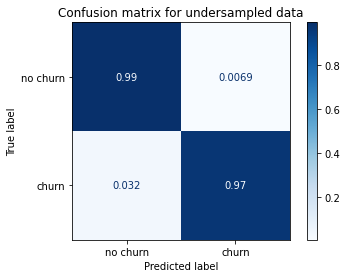

In [14]:
plot_confusion_matrix(y_test,
                     xgb_pipeline.predict(X_test),
                     "Confusion matrix for undersampled data")

XGB accuracy score with SMOTE oversampled dataset: 0.9875853507138423



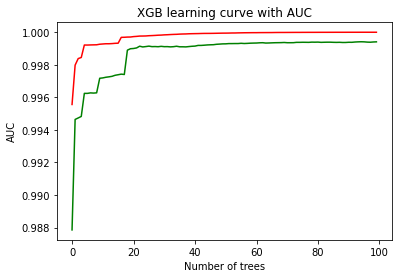

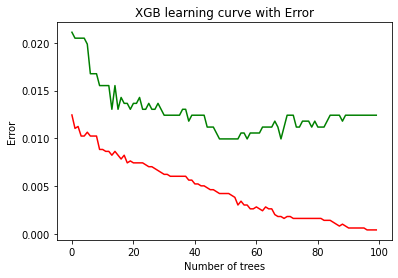

In [15]:
# accessing XGBoost incremental performance as the number of trees increases
eval_set = [(X_train_resampled, y_train_resampled), (X_test, y_test)]
eval_metric = ["auc", "error"]
xgb = XGBClassifier()
xgb.fit(X_train_resampled, 
        y_train_resampled, 
        eval_metric=eval_metric, 
        eval_set=eval_set, 
        verbose=False)
xgb_eval_results = xgb.evals_result()
# get evaluation results for train and test
xgb_train_eval = xgb_eval_results["validation_0"]
xgb_test_eval = xgb_eval_results["validation_1"]

# compute accuracy score
xgb_score = xgb.score(X_test, y_test)
print(f"XGB accuracy score with SMOTE oversampled dataset: {xgb_score}\n")

plot_learning_curve(
  train_results = xgb_train_eval["auc"],
  test_results = xgb_test_eval["auc"],
  x_label="Number of trees",
  y_label="AUC",
  title = "XGB learning curve with AUC"
)
plot_learning_curve(
  train_results = xgb_train_eval["error"],
  test_results = xgb_test_eval["error"],
  x_label="Number of trees",
  y_label="Error",
  title = "XGB learning curve with Error"
)

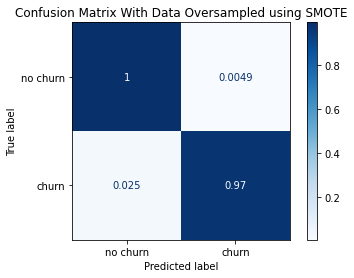

In [16]:
# plot confusion matrix
y_pred = xgb.predict(X_test)
plot_confusion_matrix(y_test,
                      y_pred,
                      "Confusion Matrix With Data Oversampled using SMOTE")

In [17]:
####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################
xgb_params_space = {
    "learning_rate": np.linspace(0.1, 0.01, 100),
    "subsample": np.linspace(0.6, 1, 10),
    "colsample_bytree": np.linspace(0.8, 1, 10),
    "gamma": [0, 1, 5],
    "max_depth": [10, 20, 30, 40, 50],
    "n_estimators": np.linspace(20, 100, 80).astype(int)
}
xgb_rs = random_search_cv_optimization(X_train_resampled, 
                              y_train_resampled,
                              XGBClassifier(),
                              xgb_params_space,
                              n_iter=10,
                              scoring="f1")

xgb_rs.best_params_

{'subsample': 1.0,
 'n_estimators': 36,
 'max_depth': 10,
 'learning_rate': 0.09,
 'gamma': 1,
 'colsample_bytree': 0.9333333333333333}

In [18]:
xgb_tuned = XGBClassifier(learning_rate=0.02, 
                          n_estimators=69, 
                          objective='binary:logistic', 
                          subsample=0.96, 
                          gamma=1, 
                          colsample_bytree=0.91, 
                          max_depth=50)
xgb_tuned.fit(X_train_resampled, y_train_resampled)

XGBClassifier(colsample_bytree=0.91, gamma=1, learning_rate=0.02, max_depth=50,
              n_estimators=69, subsample=0.96)

In [19]:
y_pred = xgb_tuned.predict(X_test)
xgb_tuned.score(X_test, y_test)

0.9851024208566108

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1014
           1       0.99      0.97      0.98       597

    accuracy                           0.99      1611
   macro avg       0.99      0.98      0.98      1611
weighted avg       0.99      0.99      0.99      1611



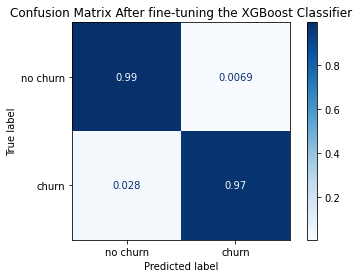

In [21]:
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix After fine-tuning the XGBoost Classifier")

## Explain XGBoost with Lime

In [22]:
# index corresponding to the test vector
i = 10
# number denoting the top features
k = 7

xgb_exp_lime = explainer_lime.explain_instance(X_test[i],
                                           xgb_pipeline.predict_proba,
                                           num_features=k)
xgb_exp_lime.show_in_notebook()

Intercept 0.8539860319155854
Prediction_local [-0.07304352]
Right: 0.00014172899


## Explain XGBoost With SHAP

In [23]:
shap_explainer_xgb = shap.TreeExplainer(xgb_tuned)
shap_values_xgb = shap_explainer_xgb.shap_values(X_test)
shap_values_xgb

array([[-3.3570098e-04,  0.0000000e+00,  9.5853122e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.4956692e-03,  0.0000000e+00, -1.4018758e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-7.4215190e-05,  0.0000000e+00, -1.2867973e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-2.6825361e-03,  0.0000000e+00,  1.8653674e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 3.2065899e-04,  0.0000000e+00,  2.7136310e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.3027738e-03,  0.0000000e+00,  2.0572462e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

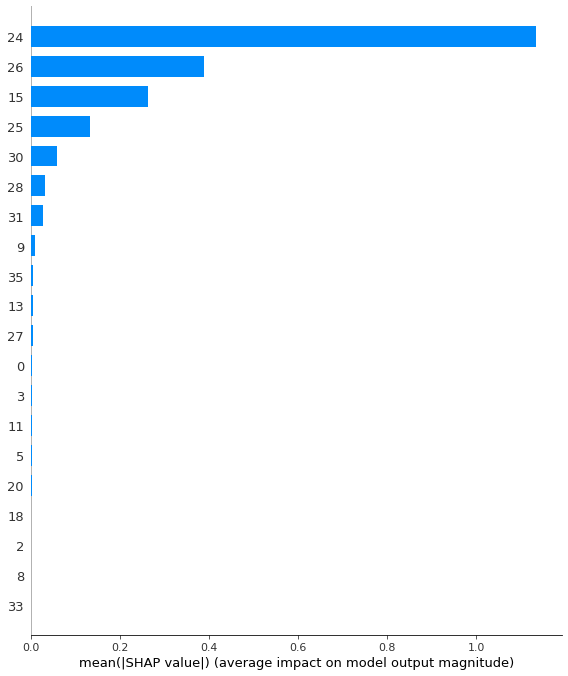

In [24]:
shap.summary_plot(shap_values_xgb, X_df, plot_type='bar')

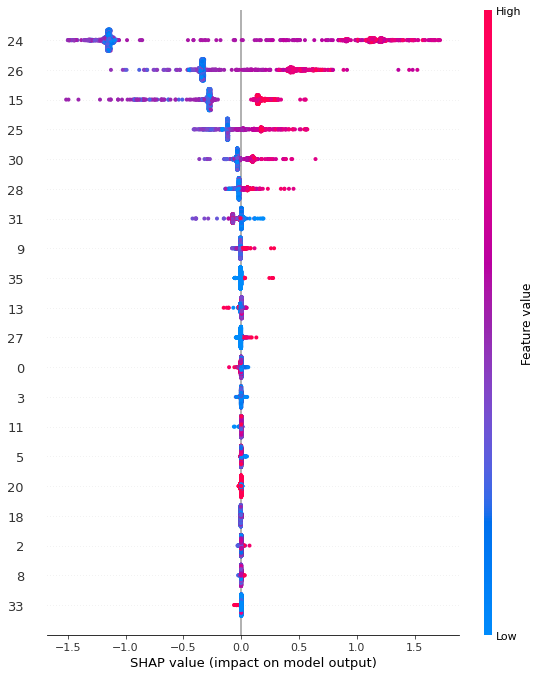

In [25]:
shap.summary_plot(shap_values_xgb, X_df)

# Logistic Regression

In [26]:
lr_pipeline = LogisticRegression()

lr_cv = RepeatedStratifiedKFold(n_splits=100, n_repeats=3, random_state=0)
lr_scores = cross_val_score(lr_pipeline, X_train, y_train, scoring='accuracy', cv=lr_cv, n_jobs=-1)
lr_scores

array([0.97368421, 1.        , 0.97368421, 1.        , 0.97368421,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.97368421, 1.        , 1.        , 0.97368421, 1.        ,
       0.94736842, 1.        , 0.97368421, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.97368421,
       1.        , 0.97368421, 0.97368421, 1.        , 1.        ,
       0.97368421, 1.        , 1.        , 1.        , 1.        ,
       0.97368421, 1.        , 0.94736842, 0.97368421, 0.97368421,
       0.94736842, 0.97368421, 1.        , 1.        , 1.        ,
       0.97368421, 1.        , 1.        , 0.97368421, 1.        ,
       1.        , 1.        , 0.97368421, 0.97368421, 1.        ,
       1.        , 0.97368421, 1.        , 1.        , 0.94594595,
       0.91891892, 1.        , 0.97297297, 0.94594595, 1.        ,
       1.        , 0.97297297, 1.        , 1.        , 1.        ,
       0.97297297, 1.        , 1.        , 0.97297297, 0.97297

In [27]:
lr_pipeline.fit(X_train_resampled, y_train_resampled)
lr_pipeline.score(X_test, y_test)

0.9851024208566108

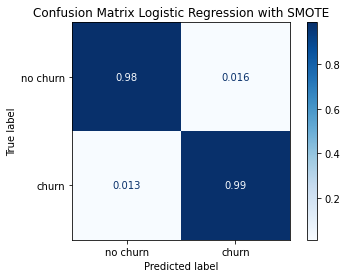

In [28]:
# plot confusion matrix
y_pred = lr_pipeline.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix Logistic Regression with SMOTE")

In [29]:
# logistic regression parameter tunning using grid search

####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

LR_params = {
              "tol": np.logspace(-0.1, 1e-6, num=100),
              "C": np.linspace(0, 1, 100),
              "penalty": ['l2', 'elasticnet', 'none'],
             "solver": ["newton-cg", "lbfgs", "sag", "saga"],
             "max_iter": np.linspace(100, 2000, 1000)
            }
lr_gs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      LogisticRegression(random_state=0),
                                      LR_params,
                                      n_iter=1000,
                                      scoring="f1"
                                      )
lr_gs.best_params_


3570 fits failed out of a total of 10000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
910 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

-------------------------

{'tol': 0.873805060557968,
 'solver': 'newton-cg',
 'penalty': 'none',
 'max_iter': 843.6436436436436,
 'C': 0.8484848484848485}

Accuracy score: 0.9453755431409062


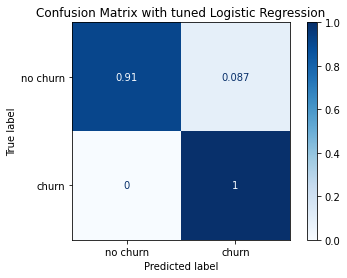

In [30]:
lr_tuned = LogisticRegression(tol=0.88,
                              penalty='l2',
                              C=0.02, random_state=0,
                              solver="saga",
                              max_iter=1381)
lr_tuned.fit(X_train_resampled, y_train_resampled)
print(f"Accuracy score: {lr_tuned.score(X_test, y_test)}")
y_pred = lr_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix with tuned Logistic Regression")

In [31]:
print(f"Logistic regression classification report \n {classification_report(y_test, y_pred)}")

Logistic regression classification report 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      1014
           1       0.87      1.00      0.93       597

    accuracy                           0.95      1611
   macro avg       0.94      0.96      0.94      1611
weighted avg       0.95      0.95      0.95      1611



In [32]:

# index corresponding to the test vector
i = 10
# number denoting the top features
k = 7

lr_exp_lime = explainer_lime.explain_instance(X_test[i],
                                           lr_pipeline.predict_proba,
                                           num_features=k)
lr_exp_lime.show_in_notebook()

Intercept 0.7805573025075072
Prediction_local [-0.53915777]
Right: 2.4206764756023395e-12


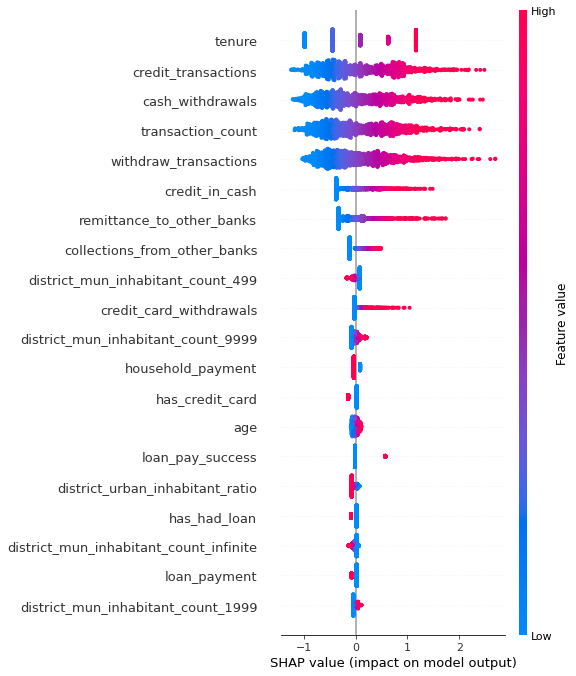

In [33]:
lr_explainer = shap.Explainer(lr_tuned, X_train, feature_names=features)
lr_shap_values = lr_explainer(X_test)

shap.summary_plot(lr_shap_values, X_df)

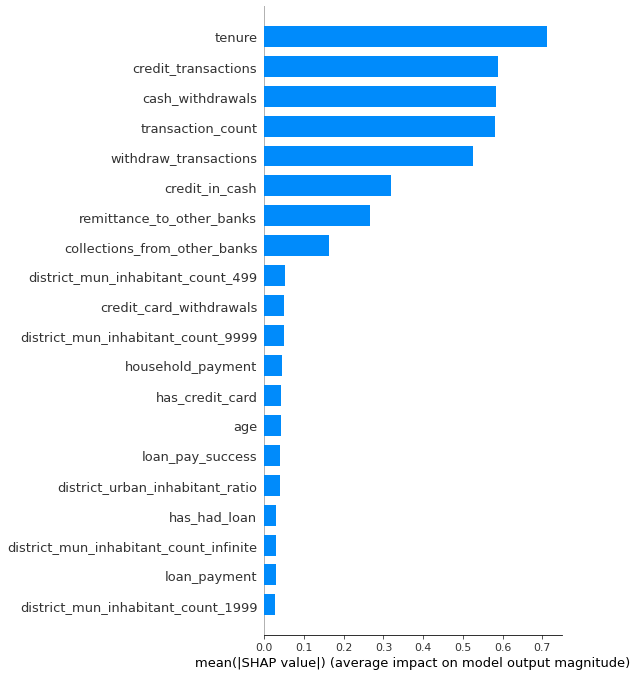

In [34]:
shap.summary_plot(lr_shap_values, X_df, plot_type="bar")

# Random Forests

In [35]:
RF_params = {
    'bootstrap': [True, False],
    'max_depth': np.linspace(70, 200, 200).astype(int),
    'max_features': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [8, 10, 11, 12, 13, 14, 15],
    'n_estimators': np.linspace(100, 1000, 900).astype(int)
}

In [36]:
rf_pipeline = RandomForestClassifier()
rf_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
rf_scores = cross_val_score(rf_pipeline,
                            X_train_resampled,
                            y_train_resampled,
                            scoring='f1',
                            cv=rf_cv,
                            n_jobs=-1)
rf_scores

array([0.99393939, 0.99799599, 0.99001996, 0.988     , 0.99396378,
       0.988     , 0.99203187, 0.99396378, 0.99398798, 0.99196787,
       0.99396378, 0.992     , 0.992     , 0.99601594, 0.99193548,
       0.99196787, 0.98210736, 0.99196787, 1.        , 0.99393939,
       0.98393574, 0.99598394, 0.98993964, 0.99401198, 0.99598394,
       0.992     , 0.98997996, 0.99396378, 0.99196787, 0.99203187])

Accuracy score: 0.983860955927995


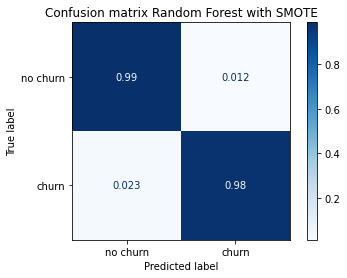

In [37]:
rf_pipeline.fit(X_train_resampled, y_train_resampled)
rf_score = rf_pipeline.score(X_test, y_test)
print(f"Accuracy score: {rf_score}")
y_pred = rf_pipeline.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion matrix Random Forest with SMOTE")

In [38]:
# Random forest parameter tunning using grid search

####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

rf_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      RandomForestClassifier(),
                                      RF_params,
                                      n_iter=10,
                                      scoring="roc_auc"
                                      )
rf_rs.best_params_

{'n_estimators': 933,
 'min_samples_split': 12,
 'min_samples_leaf': 3,
 'max_features': 3,
 'max_depth': 97,
 'bootstrap': False}

In [14]:
rf_tuned = RandomForestClassifier(
    bootstrap=False,
    max_depth=97,
    max_features=3,
    min_samples_leaf=3,
    min_samples_split=12,
    n_estimators=933
)
rf_tuned.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=False, max_depth=97, max_features=3,
                       min_samples_leaf=3, min_samples_split=12,
                       n_estimators=933)

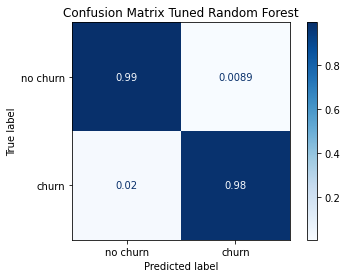

In [15]:
# plot confusion matrix
y_pred = rf_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix Tuned Random Forest")

In [16]:
rf_report = classification_report(y_test, y_pred)
print(f"Random Forest Classification Report: \n {rf_report}")

Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1014
           1       0.98      0.98      0.98       597

    accuracy                           0.99      1611
   macro avg       0.99      0.99      0.99      1611
weighted avg       0.99      0.99      0.99      1611



## Explain Random Forest with SHAP

In [17]:
shap_explainer_rf = shap.TreeExplainer(rf_tuned)
shap_values_rf = shap_explainer_rf.shap_values(X_test)
shap_values_rf

[array([[ 8.91191936e-04, -5.25791636e-04,  2.76022473e-03, ...,
          1.21793095e-04, -9.63955844e-06, -1.61259216e-05],
        [-1.57468138e-04,  6.65125152e-04,  2.78400043e-04, ...,
          2.73610558e-05, -1.46924982e-05, -1.83483418e-05],
        [-3.30634332e-03,  9.20930019e-04, -6.74308027e-04, ...,
         -1.11191062e-05, -3.22162893e-05, -3.60605557e-05],
        ...,
        [ 2.13938711e-03,  6.90343042e-04,  6.85165195e-04, ...,
          3.12482697e-05, -1.06569633e-05, -1.64238748e-05],
        [-5.70928690e-04,  2.66764617e-04,  1.64123307e-03, ...,
          2.46082482e-05, -9.86730393e-06, -1.46328492e-05],
        [-9.02583723e-04, -8.10826174e-05,  3.84664875e-04, ...,
          3.17645491e-05, -1.62020540e-05, -2.04870561e-05]]),
 array([[-8.91191936e-04,  5.25791636e-04, -2.76022473e-03, ...,
         -1.21793095e-04,  9.63955844e-06,  1.61259216e-05],
        [ 1.57468138e-04, -6.65125152e-04, -2.78400043e-04, ...,
         -2.73610558e-05,  1.46924982e

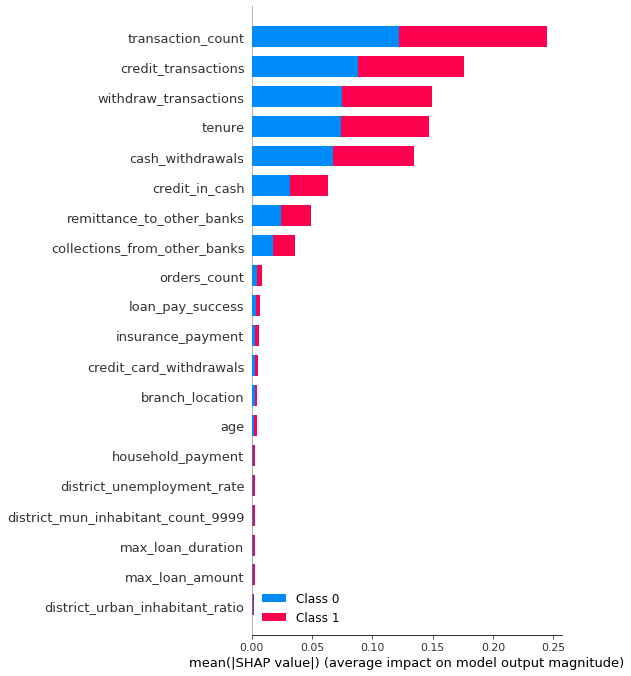

In [18]:
shap.summary_plot(shap_values_rf, X_df, feature_names=features)

In [44]:
# shap.summary_plot(shap_values_rf, X_df, plot_kind="bar")

## Explain Random Forest with LIME

In [22]:
# index corresponding to the test vector
i = 200
# number denoting the top features
k = 10

rf_exp_lime = explainer_lime.explain_instance(X_test[i],
                                           rf_tuned.predict_proba,
                                           num_features=k)
rf_exp_lime.show_in_notebook()

Intercept 0.3343388166324246
Prediction_local [0.99544715]
Right: 0.9628598005399226


# Support Vector Machines

In [46]:
svm_pipeline = SVC()
svc_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
svc_scores = cross_val_score(svm_pipeline,
                             X_train_resampled,
                             y_train_resampled,
                             scoring='accuracy',
                             cv=svc_cv,
                             n_jobs=-1)
svc_scores

array([0.98396794, 0.98797595, 0.98997996, 0.98797595, 0.98795181,
       0.99196787, 0.99196787, 0.9939759 , 0.98995984, 0.98192771,
       0.99398798, 0.99398798, 0.98797595, 0.99198397, 0.98995984,
       0.98795181, 0.97791165, 0.98594378, 0.98393574, 0.98995984,
       0.98597194, 0.99599198, 0.99198397, 0.98597194, 0.98393574,
       0.9939759 , 0.98995984, 0.9939759 , 0.98795181, 0.98795181])

In [47]:
svm_pipeline.fit(X_train_resampled, y_train_resampled)
svm_pipeline.score(X_test, y_test)

0.978895096213532

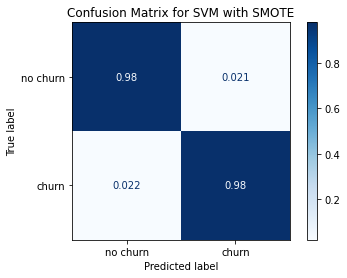

In [48]:
# plot confusion matrix
y_pred = svm_pipeline.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for SVM with SMOTE")

In [49]:
####################################################
####################################################
#                 DON'T RUN                        #
####################################################
####################################################
svm_param_grid = {'C': np.linspace(0.1, 100, 1000),
                  'gamma': ['scale', 'auto'],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'decision_function_shape': ["ovo", "ovr"]}


svm_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      SVC(),
                                      svm_param_grid,
                                      n_iter=1,
                                      scoring="balanced_accuracy"
                                      )
svm_rs.best_params_

{'kernel': 'linear',
 'gamma': 'auto',
 'decision_function_shape': 'ovr',
 'C': 17.1}

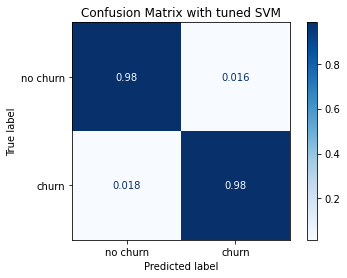

In [50]:
svm_tuned = SVC(kernel='linear',
                gamma='auto',
                decision_function_shape='ovr',
                C=17.1)
svm_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = svm_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix with tuned SVM")

In [51]:
print(f"SVM report \n {classification_report(y_test, y_pred)}")

SVM report 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1014
           1       0.97      0.98      0.98       597

    accuracy                           0.98      1611
   macro avg       0.98      0.98      0.98      1611
weighted avg       0.98      0.98      0.98      1611



## Explain SVM with SHAP

In [52]:
svm_explainer = shap.Explainer(svm_tuned,
                               X_train_resampled,
                               feature_names=features)
svm_shap_values = svm_explainer(X_test)

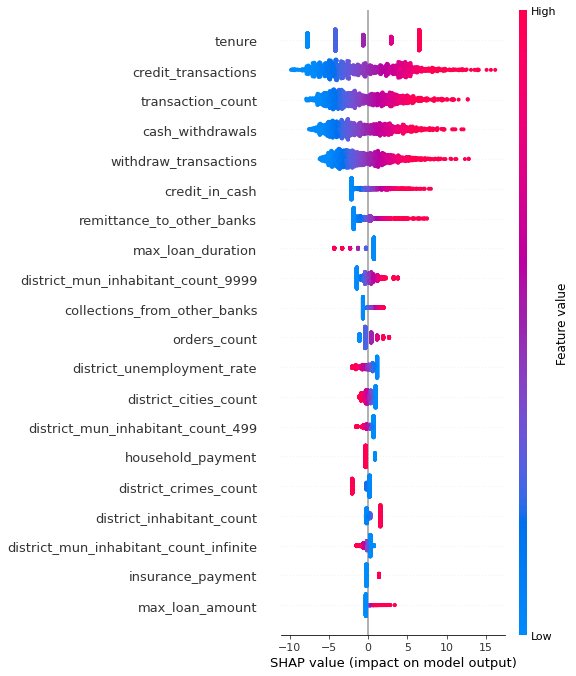

In [53]:
shap.summary_plot(svm_shap_values, X_df)

# Decision Tree

In [54]:
dt_pipeline = DecisionTreeClassifier()
dt_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
dt_scores = cross_val_score(dt_pipeline,
                            X_train_resampled,
                            y_train_resampled,
                            scoring='accuracy',
                            cv=dt_cv,
                            n_jobs=-1)
dt_scores

array([0.98797595, 0.99198397, 0.97995992, 0.98597194, 0.98795181,
       0.99196787, 0.97991968, 0.98995984, 0.9939759 , 0.98393574,
       0.98797595, 0.98997996, 0.98196393, 0.99599198, 0.98594378,
       0.98995984, 0.97188755, 0.9939759 , 0.99598394, 0.98795181,
       0.98597194, 0.98997996, 0.98597194, 0.99599198, 0.98995984,
       0.98795181, 0.98995984, 0.98995984, 0.98995984, 0.98995984])

In [55]:
dt_pipeline.fit(X_train_resampled, y_train_resampled)
dt_pipeline.score(X_test, y_test)

0.9826194909993793

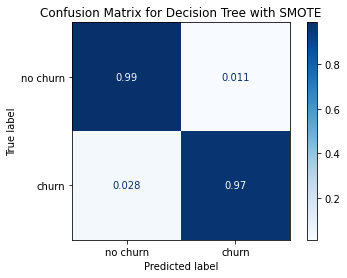

In [56]:
# plot confusion matrix
y_pred = dt_pipeline.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for Decision Tree with SMOTE")

In [57]:
# decision tree hyper parameter optimisation

####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

dt_params_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    'splitter': ["best", "random"],
    'max_depth': np.linspace(70, 200, 200).astype(int),
    'max_features': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [8, 10, 11, 12, 13, 14, 15]
    }

dt_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      DecisionTreeClassifier(),
                                      dt_params_grid,
                                      n_iter=100,
                                      scoring="roc_auc"
                                      )
dt_rs.best_params_



360 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

One or more of the test scores are non-finite: [       nan 0.99473885 0.9419596         nan        nan        nan
 0.99147853 0.99090158        nan 

{'splitter': 'best',
 'min_samples_split': 10,
 'min_samples_leaf': 7,
 'max_features': 8,
 'max_depth': 181,
 'criterion': 'gini'}

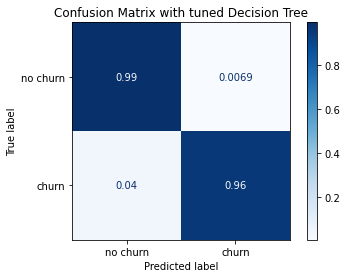

In [58]:
dt_tuned = DecisionTreeClassifier(
    splitter= 'best',
    min_samples_split= 12,
    min_samples_leaf= 9,
    max_features= 7,
    max_depth= 192,
    criterion= 'entropy'
)
dt_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = dt_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix with tuned Decision Tree")

In [59]:
print("Decision Tree Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

Decision Tree Classification Report 

              precision    recall  f1-score   support

    no churn       0.98      0.99      0.98      1014
       churn       0.99      0.96      0.97       597

    accuracy                           0.98      1611
   macro avg       0.98      0.98      0.98      1611
weighted avg       0.98      0.98      0.98      1611



## Explain Decision Tree with SHAP

In [67]:
dt_explainer = shap.TreeExplainer(dt_tuned,feature_names=features)
dt_shap_values = dt_explainer.shap_values(X_test)

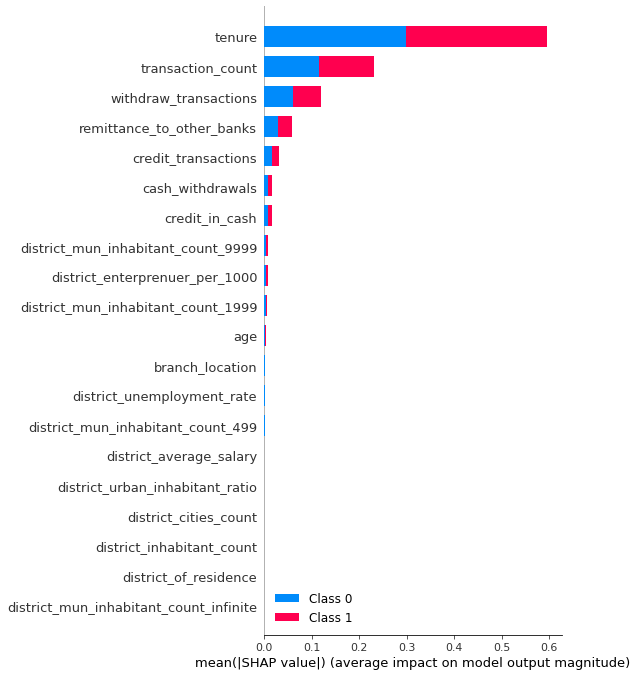

In [69]:
shap.summary_plot(dt_shap_values, X_df, feature_names=features)

# AdaBoost Classifier

In [70]:
ada_pipeline = AdaBoostClassifier()
ada_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
ada_scores = cross_val_score(ada_pipeline, X_train, y_train, scoring='accuracy', cv=ada_cv, n_jobs=-1)
ada_scores

array([0.99468085, 0.99468085, 0.9893617 , 0.98404255, 0.9893617 ,
       0.9893617 , 0.98138298, 0.99734043, 0.992     , 0.992     ,
       0.98404255, 0.98670213, 0.99202128, 0.9893617 , 0.99202128,
       0.99468085, 0.99202128, 0.99202128, 0.98666667, 0.98933333,
       0.98670213, 0.99468085, 0.9893617 , 0.9893617 , 0.98670213,
       0.99468085, 0.99734043, 0.9787234 , 0.98666667, 0.99466667])

In [71]:
ada_pipeline.fit(X_train_resampled, y_train_resampled)
ada_pipeline.score(X_test, y_test)

0.9869646182495344

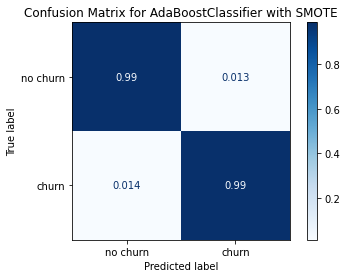

In [72]:
# plot confusion matrix
y_pred = ada_pipeline.predict(X_test)
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for AdaBoostClassifier with SMOTE")

In [73]:
# Adaboost Hyper Parameter Tuning
####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

ada_params_grid = {
    'n_estimators': np.linspace(2, 20, 18).astype(int),
    'learning_rate': np.linspace(0.1, 0.01, 100),
    'algorithm': ['SAMME', 'SAMME.R']
}

ada_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      AdaBoostClassifier(),
                                      ada_params_grid,
                                      n_iter=100,
                                      scoring="roc_auc"
                                      )
ada_rs.best_params_


{'n_estimators': 17,
 'learning_rate': 0.09727272727272727,
 'algorithm': 'SAMME.R'}

In [74]:
ada_tuned = AdaBoostClassifier(
    n_estimators=17,
    learning_rate=0.097,
    algorithm='SAMME.R'
)

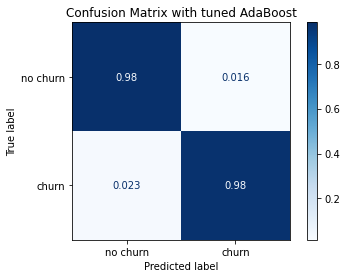

In [75]:
ada_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = ada_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix with tuned AdaBoost")

In [76]:
print("AdaBoost Ensemble Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

AdaBoost Ensemble Classification Report 

              precision    recall  f1-score   support

    no churn       0.99      0.98      0.99      1014
       churn       0.97      0.98      0.97       597

    accuracy                           0.98      1611
   macro avg       0.98      0.98      0.98      1611
weighted avg       0.98      0.98      0.98      1611



## AdaBoost with SHAP

  0%|          | 0/1611 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: 

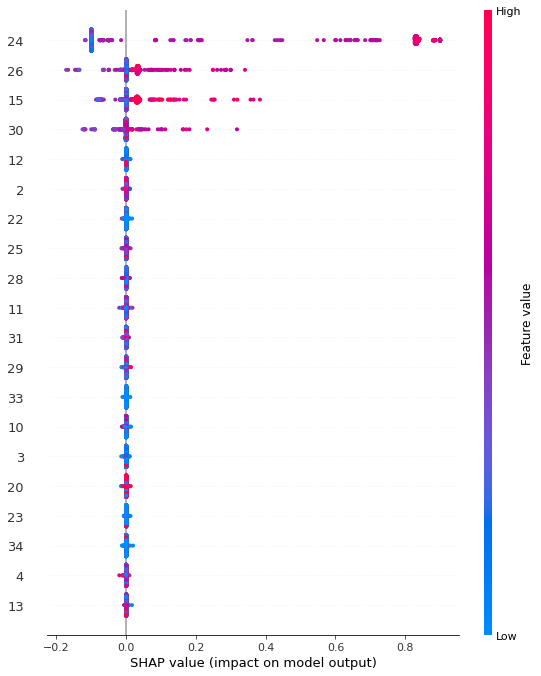

In [77]:
ada_explainer = shap.KernelExplainer(ada_tuned.predict, shap.sample(X_train, 10), feature_names=features)
ada_shap_values = ada_explainer.shap_values(X_test)

shap.summary_plot(ada_shap_values, X_df)

# Extra Trees Classifier

In [78]:
et_pipeline = ExtraTreesClassifier()
et_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
et_scores = cross_val_score(et_pipeline, X_train, y_train, scoring='accuracy', cv=et_cv, n_jobs=-1)
et_scores

array([0.98670213, 0.98670213, 0.99202128, 0.98670213, 0.99202128,
       0.98670213, 0.98138298, 0.99202128, 0.992     , 0.98933333,
       0.97340426, 0.98138298, 0.98670213, 0.99734043, 0.99202128,
       0.99202128, 0.9893617 , 0.99468085, 0.98666667, 0.99466667,
       0.98138298, 0.99202128, 0.9893617 , 0.98404255, 0.9893617 ,
       0.99202128, 0.9893617 , 0.9893617 , 0.992     , 0.992     ])

In [79]:
et_pipeline.fit(X_train, y_train)
et_pipeline.score(X_test, y_test)

0.9869646182495344

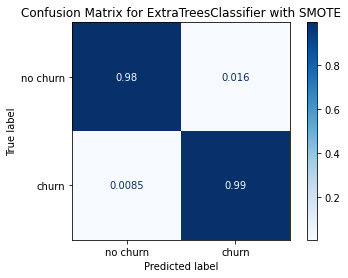

In [80]:
# plot confusion matrix
y_pred = et_pipeline.predict(X_test)
et_cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for ExtraTreesClassifier with SMOTE")

In [81]:
# ExtraTrees Hyper Parameter Tuning
####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

et_params_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    'bootstrap': [True, False],
    'max_depth': np.linspace(70, 200, 200).astype(int),
    'max_features': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [8, 10, 11, 12, 13, 14, 15],
    'n_estimators': np.linspace(100, 1000, 900).astype(int)
    }


et_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      ExtraTreesClassifier(),
                                      et_params_grid,
                                      n_iter=10,
                                      scoring="roc_auc"
                                      )
et_rs.best_params_

{'n_estimators': 879,
 'min_samples_split': 13,
 'min_samples_leaf': 4,
 'max_features': 5,
 'max_depth': 85,
 'criterion': 'gini',
 'bootstrap': False}

In [82]:
et_tuned = ExtraTreesClassifier(
    criterion="gini",
    bootstrap=False,
    max_depth=85,
    max_features=5,
    min_samples_leaf=4,
    min_samples_split=13,
    n_estimators=879
)

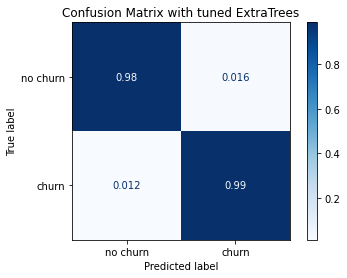

In [83]:
et_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = et_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix with tuned ExtraTrees")

In [84]:
print("ExtraTrees Ensemble Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

ExtraTrees Ensemble Classification Report 

              precision    recall  f1-score   support

    no churn       0.99      0.98      0.99      1014
       churn       0.97      0.99      0.98       597

    accuracy                           0.99      1611
   macro avg       0.98      0.99      0.98      1611
weighted avg       0.99      0.99      0.99      1611



In [85]:
# SHAP with ExtraTrees Classifier
shap_explainer_et = shap.TreeExplainer(et_tuned)
shap_values_et = shap_explainer_et.shap_values(X_test)
shap_values_et

[array([[-6.61757027e-04,  1.13699811e-03,  3.51700606e-03, ...,
          6.22096932e-05, -2.25928094e-05, -3.56938567e-05],
        [-4.06941253e-05, -1.56273569e-04,  4.75901291e-05, ...,
          6.32612039e-05, -2.88937518e-05, -4.53822482e-05],
        [-1.17267573e-03,  3.02140091e-04, -6.68647604e-04, ...,
         -2.20684815e-05, -5.83428181e-05, -8.26768319e-05],
        ...,
        [ 3.99485916e-04, -2.27790974e-04, -1.31949418e-03, ...,
          6.03723585e-05, -2.37666995e-05, -3.70942294e-05],
        [-3.53803836e-04, -1.23917802e-03,  1.26672013e-03, ...,
          2.97375770e-05, -2.29020283e-05, -3.45376087e-05],
        [-4.20504897e-05,  1.06169624e-03, -1.10382928e-04, ...,
          5.91220976e-05, -2.91557300e-05, -4.64442719e-05]]),
 array([[ 6.61757027e-04, -1.13699811e-03, -3.51700606e-03, ...,
         -6.22096932e-05,  2.25928094e-05,  3.56938567e-05],
        [ 4.06941253e-05,  1.56273569e-04, -4.75901291e-05, ...,
         -6.32612039e-05,  2.88937518e

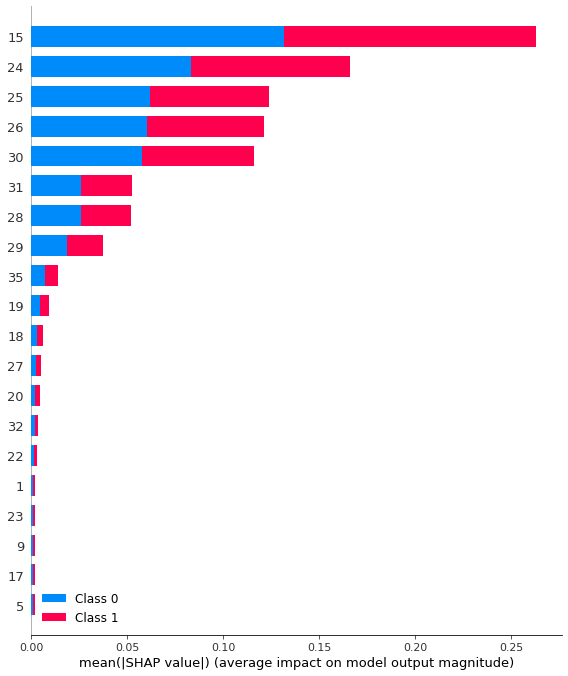

In [86]:
shap.summary_plot(shap_values_et, X_df)

# Gradient Boosting Classifier

In [87]:
gb_pipeline = GradientBoostingClassifier()

gb_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
gb_scores = cross_val_score(gb_pipeline, X_train, y_train, scoring='accuracy', cv=gb_cv, n_jobs=-1)
gb_scores

array([0.98670213, 0.99468085, 0.99468085, 0.98670213, 0.99468085,
       0.98670213, 0.9787234 , 0.99468085, 0.98933333, 0.992     ,
       0.97606383, 0.99202128, 0.98404255, 1.        , 0.99468085,
       0.99468085, 0.98670213, 0.9893617 , 0.992     , 0.99466667,
       0.9893617 , 0.99202128, 0.99468085, 0.9787234 , 0.9893617 ,
       0.99202128, 0.99202128, 0.98404255, 0.98933333, 0.99466667])

In [88]:
gb_pipeline.fit(X_train, y_train)
gb_pipeline.score(X_test, y_test)

0.9851024208566108

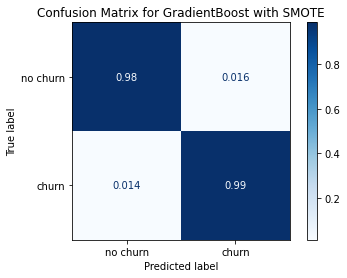

In [89]:
# plot confusion matrix
y_pred = gb_pipeline.predict(X_test)
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for GradientBoost with SMOTE")

In [90]:
# Gradient Boost Parameter Tuning


####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

gb_params_grid = {
    'loss': ['log_loss', 'deviance', 'exponential'],
    "learning_rate": np.linspace(0.1, 0.01, 100),
    'criterion': ["friedman_mse", "squared_error"],
    'max_depth': np.linspace(70, 200, 200).astype(int),
    'max_features': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [8, 10, 11, 12, 13, 14, 15],
    'n_estimators': np.linspace(100, 1000, 900).astype(int)
    }


gb_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      GradientBoostingClassifier(),
                                      gb_params_grid,
                                      n_iter=10,
                                      scoring="roc_auc"
                                      )
gb_rs.best_params_


10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not supported. 

One or more of the test scores are non-finite: [0.99978458 0.99978135        nan 0.9998

{'n_estimators': 495,
 'min_samples_split': 13,
 'min_samples_leaf': 7,
 'max_features': 3,
 'max_depth': 186,
 'loss': 'exponential',
 'learning_rate': 0.04818181818181818,
 'criterion': 'squared_error'}

In [91]:
gb_tuned = GradientBoostingClassifier(
    loss='exponential',
    learning_rate=0.05,
    criterion='squared_error',
    max_depth=186,
    max_features=3,
    min_samples_leaf=7,
    min_samples_split=13,
    n_estimators=495
)

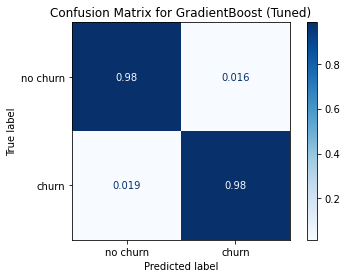

In [92]:
gb_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = gb_tuned.predict(X_test)
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for GradientBoost (Tuned)")

In [93]:
print("Gradient Boosting Ensemble Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

Gradient Boosting Ensemble Classification Report 

              precision    recall  f1-score   support

    no churn       0.98      0.99      0.99      1014
       churn       0.98      0.97      0.98       597

    accuracy                           0.98      1611
   macro avg       0.98      0.98      0.98      1611
weighted avg       0.98      0.98      0.98      1611



# KNeighbours Classifier

In [94]:
kn_pipeline = KNeighborsClassifier()
kn_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
kn_scores = cross_val_score(kn_pipeline, X_train, y_train, scoring='accuracy', cv=kn_cv, n_jobs=-1)
kn_scores

array([0.94680851, 0.95478723, 0.96542553, 0.95212766, 0.96276596,
       0.94148936, 0.94946809, 0.94414894, 0.95466667, 0.952     ,
       0.94946809, 0.93085106, 0.94680851, 0.94680851, 0.96542553,
       0.93882979, 0.94946809, 0.96808511, 0.95733333, 0.96      ,
       0.95212766, 0.97606383, 0.95478723, 0.94414894, 0.93882979,
       0.95478723, 0.95212766, 0.95744681, 0.94666667, 0.952     ])

In [95]:
kn_pipeline.fit(X_train, y_train)
kn_pipeline.score(X_test, y_test)

0.9497206703910615

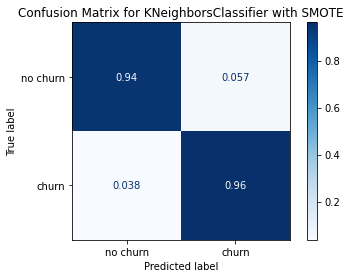

In [96]:
y_pred = kn_pipeline.predict(X_test)
kn_cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for KNeighborsClassifier with SMOTE")

In [97]:
# KNeighbors Parameter Optimization

####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

knn_params_grid = {
    'n_neighbors': np.linspace(3, 10, 7).astype(int),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': np.linspace(30, 100, 7).astype(int),
    'p': [1, 2]
    }


knn_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      KNeighborsClassifier(),
                                      knn_params_grid,
                                      n_iter=10,
                                      scoring="balanced_accuracy"
                                      )
knn_rs.best_params_

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'weights': 'distance',
 'p': 1,
 'n_neighbors': 8,
 'leaf_size': 65,
 'algorithm': 'brute'}

In [98]:
knn_tuned = KNeighborsClassifier(
    n_neighbors=4,
    weights='distance',
    algorithm='brute',
    leaf_size=65,
    p=1
)

In [99]:
knn_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = knn_tuned.predict(X_test)

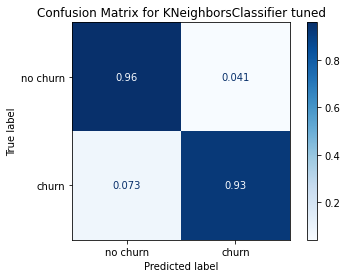

In [100]:
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for KNeighborsClassifier tuned")

In [101]:
print("KNeighbors Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

KNeighbors Classification Report 

              precision    recall  f1-score   support

    no churn       0.96      0.96      0.96      1014
       churn       0.93      0.93      0.93       597

    accuracy                           0.95      1611
   macro avg       0.94      0.94      0.94      1611
weighted avg       0.95      0.95      0.95      1611



# Voting Classifier

In [102]:
clf1 = RandomForestClassifier()
clf2 = ExtraTreesClassifier()
clf3 = GradientBoostingClassifier()
clf4 = SVC()
clf5 = DecisionTreeClassifier()
estimators = [('rf', clf1),
              ('et', clf2), 
              ('gb', clf3), 
              ('svm', clf4), 
              ('dt', clf5)
             ]

v_pipeline = VotingClassifier(estimators=estimators)
v_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
v_scores = cross_val_score(v_pipeline,
                           X_train_resampled,
                           y_train_resampled,
                           scoring='accuracy',
                           cv=v_cv,
                           n_jobs=-1)
v_scores

array([0.99599198, 1.        , 0.98797595, 0.98997996, 0.99196787,
       0.99598394, 0.98995984, 0.9939759 , 0.9939759 , 0.99196787,
       0.99599198, 0.99398798, 0.99198397, 0.99799599, 0.99196787,
       0.98795181, 0.98594378, 0.99196787, 1.        , 0.99196787,
       0.98997996, 0.99799599, 0.99198397, 0.99799599, 0.9939759 ,
       0.99196787, 0.99196787, 0.9939759 , 0.99196787, 0.9939759 ])

In [118]:
v_pipeline.fit(X_train_resampled, y_train_resampled)
v_pipeline.score(X_test, y_test)

0.9857231533209186

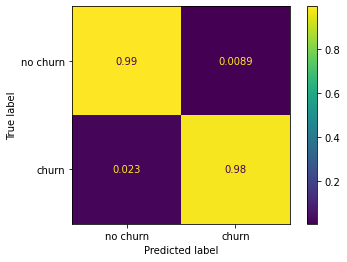

In [119]:
y_pred = v_pipeline.predict(X_test)
v_cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
metrics.ConfusionMatrixDisplay(confusion_matrix=v_cm,
                               display_labels=["no churn", "churn"] ).plot()
plt.show()

In [120]:
print("Voting Ensemble Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

Voting Ensemble Classification Report 

              precision    recall  f1-score   support

    no churn       0.99      0.99      0.99      1014
       churn       0.98      0.98      0.98       597

    accuracy                           0.99      1611
   macro avg       0.99      0.98      0.98      1611
weighted avg       0.99      0.99      0.99      1611



# Extreme Learning Machine

In [122]:
from scipy.linalg import pinv2

INPUT_SIZE = X_train.shape[1]
HIDDEN_SIZE = 1000

input_weights = np.random.normal(size=[INPUT_SIZE, HIDDEN_SIZE])
biases = np.random.normal(size=[HIDDEN_SIZE])

def relu(x):
  return np.maximum(x, 0, x)

def hidden_nodes(X):
  G = np.dot(X, input_weights)
  G = G + biases
  H = relu(G)
  return H

output_weights = np.dot(pinv2(hidden_nodes(X_train_resampled)), y_train_resampled)

scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead


In [123]:
def predict(X):
  out = hidden_nodes(X)
  out = np.dot(out, output_weights)
  return out 

In [124]:
prediction = predict(X_test)
correct = 0
total = X_test.shape[0]

for i in range(total):
  predicted = 1 if prediction[i] > 0.5 else 0
  actual = list(y_test)[i]
  correct += 1 if predicted == actual else 0

accuracy = correct/total
print(f"Accuracy for {HIDDEN_SIZE} hidden nodes: {accuracy}")

Accuracy for 1000 hidden nodes: 0.957169459962756


In [125]:
prediction.shape

(1611,)

In [126]:
y_pred = [1 if i > 0.5 else 0 for i in prediction]

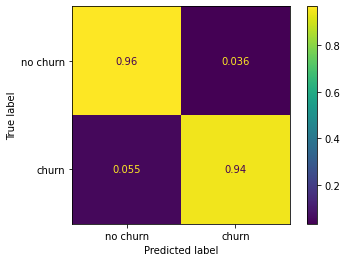

In [127]:
kn_cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
metrics.ConfusionMatrixDisplay(confusion_matrix=kn_cm,
                               display_labels=["no churn", "churn"] ).plot()
plt.show()

In [128]:
print("ELM Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

ELM Classification Report 

              precision    recall  f1-score   support

    no churn       0.97      0.96      0.97      1014
       churn       0.94      0.94      0.94       597

    accuracy                           0.96      1611
   macro avg       0.95      0.95      0.95      1611
weighted avg       0.96      0.96      0.96      1611

